# Improve eddy tracking

The objective of this script is to improve the eddy tracking and remove all the bugs found in the first stage of development. 

In [1]:
# Importing all libraries except trackeddy.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *

In [2]:
# Output data path
outputpath='/g/data/v45/akm157/model_output/mom/mom01v5_kds75/output306/'
# Import SSH values to python environment.
ncfile=Dataset(outputpath+'rregionsouthern_ocean_daily_eta_t.nc')
eta=ncfile.variables['eta_t'][:]*100
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean_sub01'][:]
lat=ncfile.variables['yt_ocean_sub01'][:]

In [ ]:
# Track eddy script used to update and remove bugs, It should be the same as the trackeddy.py file.
import numpy as np
import numpy.ma as ma
import pylab as plt
from mpl_toolkits.basemap import Basemap

def scan_eddym(ssh,lon,lat,levels,date,areamap,destdir='',okparm='',diagnostics=False):
    '''
    *************Scan Eddym***********
    Function to identify each eddy using closed contours,
    also this function checks if the elipse adjusted have
    a consistent eccentricity, vorticty and other parameters.
    Usage:
    ssh= Sea Surface Height in cm
    lon,lat=longitude and latitude of your grid.
    levels=where the code will find the closed contours.
    date=date in julian days
    areamap=Section of interest
    
    Example:
    ssh=Read netCDF4 data with mask or create a mask for your data
    lon=Import your longitude coordinates, if your grid is regular, you can use a linspace instead
    lat=Import your latitude coordinates (same as above).
    levels=List of the levels in which ones you want to find the eddies
    date=Date as Julian Days
    areamap=array([[0,len(lon)],[0,len(lat)]]) Array with the index of your area of interest.
    I used some auxilar functions, each one has his respective author.
    Author: Josue Martinez Moreno, 2017
    '''
    ellipse_path=[]
    contour_path=[]
    position=[]
    area=[]
    level=[]
    shapedata=np.shape(ssh)
    if ssh is ma.masked:
        print 'Invalid ssh data, must be masked'
        return
    if shapedata == [len(lat), len(lon)]:
        print 'Invalid ssh data size, should be [length(lat) length(lon]'
        return
    if np.shape(areamap) == shapedata:
        if np.shape(areamap) == [1, 1] | len(areamap) != len(lat):
            print 'Invalid areamap, using NaN for eddy surface area'
        return
    #Saving mask for future post-processing.  
    mask=ma.getmask(ssh)
    sshnan=ssh.filled(np.nan)
    #sshnan=ma.masked_array(okparm, mask=mask[0,:,:])
    #sshnan=sshnan.filled(nan)
    #Obtain the contours of a surface (contourf), this aproach is better than the contour.
    if len(np.shape(lon))== 1 and len(np.shape(lat)) == 1:
        Lon,Lat=np.meshgrid(lon,lat)
    else:
        Lon,Lat=lon,lat
    
    min_x=Lon[0,0]
    min_y=Lat[0,0]
    max_x=Lon[-1,-1]
    max_y=Lat[-1,-1]
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    m = Basemap(projection='ortho',lat_0=-90,lon_0=-100,resolution='f')
    
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
    lonm,latm=m(Lon,Lat)
    
    if len(shapedata)==3:
        m.contourf(lonm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                   latm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                sshnan[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
        plt.show()
        CS=plt.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                sshnan[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
        plt.close()
    else:
        m.contourf(lonm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                   latm[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],\
                sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
        plt.show()
        CS=plt.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                sshnan[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels)
        plt.close()
        
    CONTS=CS.allsegs[:][:]
    #Loop in contours of the levels defined.
    print CS.levels
    total_contours=0
    total_eddy=[]
    eddyn=0
    for ii in range(0,np.shape(CONTS)[0]):
        CONTSlvls=CONTS[ii]
        for jj in range(0,np.shape(CONTSlvls)[0]):
            CONTeach=CONTSlvls[jj]
            if (len(CONTeach[:,0]) | len(CONTeach[:,1])) <= 20:
                #print 'Singular index I cant get an ellipse with this data'
                xx=np.nan
                yy=np.nan
                center=[np.nan,np.nan]
                check=False
            else:
                ellipse = fitEllipse(CONTeach[:,0],CONTeach[:,1])
                center = ellipse_center(ellipse)
                phi = ellipse_angle_of_rotation(ellipse)
                axes = ellipse_axis_length(ellipse)
                R = np.arange(0,2.1*np.pi, 0.1)
                a,b = axes
                #Ellipse coordinates.
                xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
                yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
                #Area of Contours (contarea) and ellipse (ellipsarea)
                contarea=PolyArea(CONTeach[:,0],CONTeach[:,1])
                ellipsarea=PolyArea(xx,yy)
                # Linear Eccentricity check
                eccen=eccentricity(a,b)
                #Record and check how many grid points have land or masked values
                landcount=0
                for ii in range(0,len(CONTeach[:,0])):
                    idxcheck,idycheck=find2d(lon,lat,CONTeach[ii,0],CONTeach[ii,1])
                    idxelipcheck,idyelipcheck=find2d(lon,lat,center[0],center[1])
                    if len(shapedata)==3:
                        if sshnan[date,idycheck,idxcheck]==np.nan:
                            landcount=countzeros+1
                    else:
                        if sshnan[idycheck,idxcheck]==np.nan:
                            landcount=countzeros+1
                if landcount>=len(CONTeach[:,0])/2:
                    #print 'Thisone is land'
                    check=False
                else:
                    if contarea>ellipsarea:
                        if contarea/1.5>ellipsarea:
                            #print 'Removing contour, thisone is really underestimate'
                            check=False
                        else:
                            if ellipsarea < 400 or contarea<400:
                                #print 'Saving contour in path:'
                                check=True
                            else:
                                check=False
                    elif contarea<ellipsarea:
                        if contarea<ellipsarea/1.5:
                            #print 'Removing contour, thisone is really overestimate'
                            check=False
                        elif eccen<0.99 and eccen>0.6:
                            if ellipsarea < 400 or contarea<400:
                            #print 'Saving contour in path:'
                                check=True
                            else:
                                check=False
                        else:
                            #print 'Removing contour, thisone is really underestimate'
                            check=False
                    else:
                        check=False
                if diagnostics == True:
                    print("Ellipse parameters")
                    print("center = ",  center)
                    print("angle of rotation = ",  phi)
                    print("axes (a,b) = ", axes)
                    print("Eccentricity = ",eccen)
                    print("Area = ",contarea,ellipsarea)
                if check==True:# or check==False:
                    #Save data each eddy
                    #print ellipse_path
                    ellipse_path.append([xx,yy])
                    contour_path.append([CONTeach[:,0],CONTeach[:,1]])
                    position.append(center)
                    total_eddy.append(eddyn)
                    area.append(contarea)
                    level.append(0)
                    eddyn=eddyn+1
                    if diagnostics == True:
                        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6))
                        if len(shapedata)==3:
                            ax1.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]])
                        else:
                            ax1.contourf(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]])
                        ax1.plot(CONTeach[:,0],CONTeach[:,1],'*r')
                        ax1.plot(xx,yy,'-b')
                        ax1.plot(center[0],center[1],'ob')
                        if len(shapedata)==3:
                            cc=ax2.pcolormesh(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],vmin=min(levels),\
                                vmax=max(levels))
                            cca=ax2.contour(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[date,areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels,cmap='jet')
                            ax2.clabel(cca, fontsize=9, inline=1)
                        else:
                            cc=ax2.pcolormesh(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],vmin=min(levels),\
                                vmax=max(levels))
                            cca=ax2.contour(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]],\
                                ssh[areamap[1,0]:areamap[1,1],areamap[0,0]:areamap[0,1]],levels=levels,cmap='jet')
                            ax2.clabel(cca, fontsize=9, inline=1)
                        f.subplots_adjust(right=0.8)
                        cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
                        f.colorbar(cc, cax=cbar_ax)
                        ax2.plot(CONTeach[:,0],CONTeach[:,1],'-r')
                        ax2.plot(xx,yy,'-b')
                        ax2.plot(center[0],center[1],'ob')
                        #x, y = np.meshgrid(lon[areamap[0,0]:areamap[0,1]],lat[areamap[1,0]:areamap[1,1]])
                        #c = np.ones_like(x)
                        ax2.plot(lon[idxelipcheck],lat[idyelipcheck],'om')
                        #ax2.pcolor(x, y, c, facecolor='none', edgecolor='k')
                        ax2.set_ylim([CONTeach[:,1].min(),CONTeach[:,1].max()])
                        ax2.set_xlim([CONTeach[:,0].min(),CONTeach[:,0].max()])
                        plt.show()
                        plt.close()
            total_contours=total_contours+1
    contour_path=np.array(contour_path)
    ellipse_path=np.array(ellipse_path)
    possition=np.array(position)
    level=np.array(level)
    eddys=dict_eddym(contour_path, ellipse_path,position,area,total_eddy,level)
#    if destdir!='':
#        save_data(destdir+'day'+str(date)+'_one_step_cont'+str(total_contours)+'.dat', variable)
    print "The total of contours was", total_contours
    return eddys
    
def scan_eddyt(ssh,lat,lon,levels,date,areamap,destdir='',okparm='',diagnostics=False):
    '''
    SCAN_EDDY Scan all of the ssh data passed in (will function correctly if data passed in is a subset)
    ssh: ssh cube with nans for land
    lat: A 1D array of double's that gives the latitude for a given index in ssh data , should be equal to size(ssh, 1)
    lon: A 1D array of double's that gives the longitude for a given index in ssh data, should be equal to size(ssh, 2)
    dates: A 1D array of the dates of ssh data, length should be equal to shape(ssh)[0] 
    destdir: destination directory to save eddies
    '''
    #if destdir!='' or os.path.isdir(destdir)==False:
    #    os.makedirs(directory)
    if len(np.shape(ssh))==3:
        if date==0:
            print 'Please change the date to the number of iteratios you want'
    else:
        print 'Please use the other function scan_eddym'
        return
    for tt in range(0,date):
        print "**********Starting iteration ",tt,"**********"
        eddys=scan_eddym(ssh[tt,:,:],lon,lat,levels,tt,areamap,destdir='',okparm=okparm,diagnostics=diagnostics)
        if tt==0:
            eddytd=dict_eddyt(tt,eddys)
        else:
            eddytd=dict_eddyt(tt,eddys,eddytd) 
        print "**********Finished iteration ",tt,"**********"
    if destdir!='':
        save_data(destdir+str(date),eddies)
    return eddytd

In [ ]:
# Import SSH values to python environment.
ncfile=Dataset('/home/156/jm5970/notebooks/traceddy/data.output/meanssh_10yrs_AEXP.nc')
print ncfile

ssh_mean=ncfile.variables['SSH_mean'][:]
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['lon'][:]
lat=ncfile.variables['lat'][:]

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: SSH mean of the Southern Ocean over 10 years
    history: Created 31/07/17
    dimensions(sizes): lon(3600), lat(931), time(345)
    variables(dimensions): float32 Longitude(lon), float32 Latitude(lat), int32 Time(time), float32 SSH_mean(time,lon,lat)
    groups: 



0


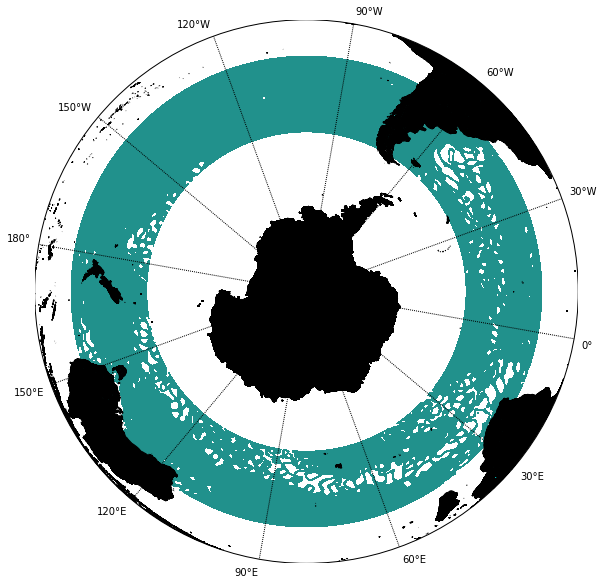

[-10, 10]
The total of contours was 14
('ts', 0)
1


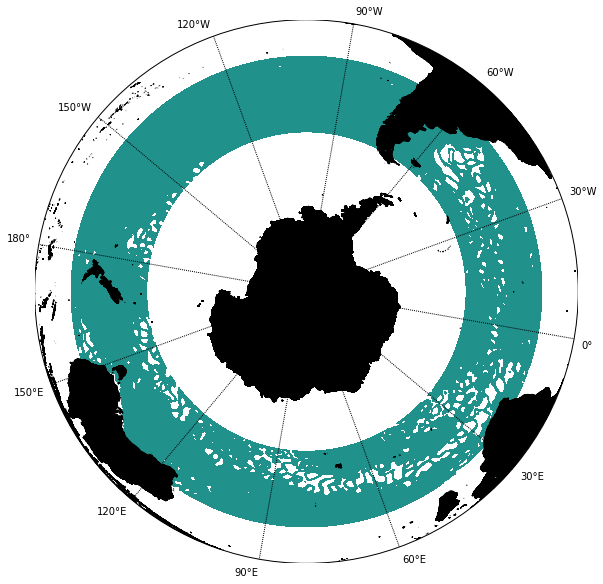

[-10, 10]
The total of contours was 11
('ts', 1)
eddyn_0


KeyError: 'time'

In [6]:
areamap=array([[0,len(lon)],[600,len(lat)]])
levels=[-10,10]
for ii in range(0,shape(eta)[0]):
    print ii
    ssha=eta[ii,:,:]-sshmean
    eddys=scan_eddym(ssha,lon,lat,levels,ii,areamap,destdir='',okparm='',diagnostics=False)
    if ii==0:
        eddytd=dict_eddyt(ii,eddys)
    else:
        eddytd=dict_eddyt(ii,eddys,eddytd) 

In [ ]:
#4,2,3
eddy='eddyn_22'
#print eddytd[eddy]['position']
for ii in range(0,len(eddytd[eddy]['time'])):
    rdd=eddytd[eddy]['time'][ii][0]
    print rdd
    dd="%03d" % ii
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6))
    ax1.pcolormesh(lon,lat,eta[rdd,:,:])
    ax1.plot(eddytd[eddy]['position'][ii,0],eddytd[eddy]['position'][ii,1],'*r')
    ax1.plot(eddytd[eddy]['contour'][ii,0],eddytd[eddy]['contour'][ii,1],'-m')
    c1,c2=find2d(lon,lat,eddytd[eddy]['contour'][ii,0].min(),eddytd[eddy]['contour'][ii,1].min())
    c3,c4=find2d(lon,lat,eddytd[eddy]['contour'][ii,0].max(),eddytd[eddy]['contour'][ii,1].max())
    ax2.contourf(lon[c1-4:c3+4],lat[c2-4:c4+4],eta[rdd,c2-4:c4+4,c1-4:c3+4])
    ax2.plot(eddytd[eddy]['position'][0:ii+1,0],eddytd[eddy]['position'][0:ii+1,1],'-r')
    ax2.plot(eddytd[eddy]['position'][0:ii+1,0],eddytd[eddy]['position'][0:ii+1,1],'*r')
    ax2.plot(eddytd[eddy]['contour'][ii,0],eddytd[eddy]['contour'][ii,1],'-m')
    #print eddytd['eddyn_14']['contour'][:,1]
    #print u[ii,c2:c4,c1:c3]
    #print lonu[c1],lonu[c3],latu[c2],latu[c4]
    #ax2.streamplot(lonu[c1:c3],latu[c2:c4],u[ii,c2:c4,c1:c3],v[rdd,c2:c4,c1:c3])
    #ax2.set_ylim([eddytd[eddy]['contour'][ii,1].min(),eddytd[eddy]['contour'][ii,1].max()])
    #ax2.set_xlim([eddytd[eddy]['contour'][ii,0].min(),eddytd[eddy]['contour'][ii,0].max()])
    ax2.set_title('Day '+str(rdd))
    f.savefig('../output/'+eddy+str(dd)+'.png', bbox_inches='tight')
#eddytd['eddyn_14']
#figure()
#streamplot(lonu,latu,u[ii,:,:],v[ii,:,:], density=1)